# IEEE-CIS Fraud Detection


## Setup

In [2]:
import pandas as pd 


In [3]:
MODEL_ID=0


In [4]:
DATA_PATH = "data"
VERBOSE = True 
R_S = 42
VAL_SIZE = 0.2
VIF_DELETE_THRESH=10


RESULTS_JSON = "models/results.json"
MODEL_ID_FILE = "models/model_id.txt"



In [ ]:
train_transaction = pd.read_csv(f"{DATA_PATH}/train_transaction.csv")
train_identity = pd.read_csv(f"{DATA_PATH}/train_identity.csv")

test_transaction = pd.read_csv(f"{DATA_PATH}/test_transaction.csv")
test_identity = pd.read_csv(f"{DATA_PATH}/test_identity.csv")

print(train_transaction.shape)
print(c.shape)

(590540, 394)
(144233, 41)


## 1. Exploratory Data Analysis


### 1.1 Data description (Kaggle) 
The data is broken into two files `identity` and `transaction`, which are joined by `TransactionID`. **TODO: Not all transactions have corresponding identity information.**

**Categorical Features - Transaction**
- ProductCD
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9

**Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38

The `TransactionDT` feature is a timedelta from a given reference datetime (not an actual timestamp).

**Files**
- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set 
- sample_submission.csv - a sample submission file in the correct format

The goal is to predict the isFraud value for these observation. 

### 1.2 Data interpretation: 
1. General discussion:  https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203 
2. Lynn@Vesta interpretation: 

**Transaction table**:
- TransactionDT: timedelta from a given reference datetime (not an actual timestamp).  
(Tudor Lapusant interpretation: Timedelta from a given reference datetime (not an actual timestamp) **“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”**
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
- Categorical Features: ProductCD card1 - card6 addr1, addr2 P_emaildomain R_emaildomain M1 - M9.  

**Identity table**: 
Variables in this table are: 
- identity information – network connection information (IP, ISP, Proxy, etc) 
- digital signature (UA/browser/os/version, etc) associated with transactions.  
They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)
- Categorical Features: DeviceType DeviceInfo id_12 - id_38. 







In [6]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#train_transaction.isna().mean().sort_values(ascending=False)

In [8]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [9]:
#train_identity.isna().mean().sort_values(ascending=False)

In [10]:
# Merge the transaction, identity tables
# left join because: "Not all transactions have corresponding identity information."

train_df = train_transaction.merge(
    train_identity,
    on="TransactionID",
    how="left"
)

X_test = test_transaction.merge(
    test_identity,
    on="TransactionID",
    how="left"
)


In [11]:
y = train_df["isFraud"]
X = train_df.drop(columns=["isFraud"])

In [12]:
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [13]:
y.value_counts(normalize=True)


isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=VAL_SIZE,
    random_state=R_S,
    stratify=y
)


### 1.3 Missing rate 

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
missing_rate = train_df.isna().mean()
missing_rate

TransactionID     0.000000
isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
                    ...   
id_36             0.761261
id_37             0.761261
id_38             0.761261
DeviceType        0.761557
DeviceInfo        0.799055
Length: 434, dtype: float64

In [17]:
n_features = len(missing_rate)

n_ge_75 = (missing_rate >= 0.75).sum()
n_ge_85 = (missing_rate >= 0.85).sum()

print(f"Total features: {n_features}")
print(f"Features with missing rate >= 0.75: {n_ge_75} ({n_ge_75 / n_features:.1%})")
print(f"Features with missing rate >= 0.85: {n_ge_85} ({n_ge_85 / n_features:.1%})")


Total features: 434
Features with missing rate >= 0.75: 208 (47.9%)
Features with missing rate >= 0.85: 74 (17.1%)


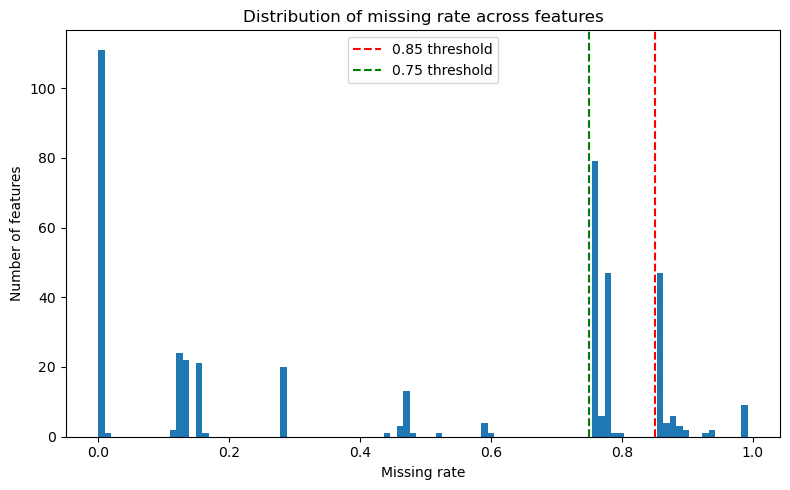

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(missing_rate, bins=100)
plt.axvline(0.85, c='r', linestyle="--", label="0.85 threshold")
plt.axvline(0.75, c='g', linestyle="--", label="0.75 threshold")

plt.xlabel("Missing rate")
plt.ylabel("Number of features")
plt.title("Distribution of missing rate across features")
plt.legend()
plt.tight_layout()
plt.show()


### 1.4 Categorical variables

### 1.5 VIF

In [19]:
import numpy as np
import pandas as pd

X_train_num = X_train.select_dtypes(include=["number"]).copy()
X_train_num = X_train_num.dropna(axis=1, how='all')
X_train_num = X_train_num.fillna(X_train_num.median())
X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(X_train_num.median())

# Calculate VIF based on inverse corr matrix (VIF values are on the diagonal)
# variance_inflation_factor was to slow
corr_matrix = X_train_num.corr()
vif_values = np.linalg.inv(corr_matrix.values).diagonal()


vif_data = pd.DataFrame({
    "feature": X_train_num.columns,
    "VIF": vif_values
})

print(vif_data.sort_values(by="VIF", ascending=False))

    feature           VIF
136     V97  6.945494e+06
142    V103  5.975416e+06
135     V96  5.326162e+06
141    V102  4.249084e+06
134     V95  3.073078e+06
..      ...           ...
4     card2  1.023486e+00
3     card1  1.017347e+00
40       V1  1.013929e+00
7     addr1  1.012169e+00
344    V305  1.000288e+00

[402 rows x 2 columns]


We observe huge values. Many properties contain information which can be explained by other variables (multicollinearity). Normally we drop when VIF > 10 - the values of $10^6$ are extreme.

## 2. Data preprocessing

In [20]:
def preprocess_data(df):
    return df

### 2.1 Missing data handling

#### Missing data patterns 
TODO

### Feature engineering 

## 3. Models 

### 3.1 Baseline 
The data preprocessing functions defined above are not utalized by the baseline models. Instead we use simple strategies:   
a) drop all categorical data,  drop numerical data where missing threshold $\ge$ missing_thresh, data imputation: median   
b) numerical variables as above, but we drop categorical variables with $\geq$ 250 unique values and then use one-hot (in practise, only 'DeviceInfo' with ~2000 unique values will be deleted).    

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, average_precision_score

import time
import joblib
from datetime import datetime

In [22]:
import os 
import json 


MODEL_ID_FILE = "models/model_id.txt"

def _get_next_model_id(path=MODEL_ID_FILE):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)

    if not os.path.exists(path):
        with open(path, "w") as f:
            f.write("0")

    with open(path, "r") as f:
        mid = int(f.read().strip())

    new_mid = mid + 1

    tmp = path + ".tmp"
    with open(tmp, "w") as f:
        f.write(str(new_mid))
    os.replace(tmp, path)  # atomic

    return mid


def _append_json_atomic(record, path="models/results.json"):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)

    data = []
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            with open(path, "r", encoding="utf-8") as f:
                data = json.load(f)
            if not isinstance(data, list):
                data = [data]
        except Exception:
            data = []

    data.append(record)

    tmp = path + ".tmp"
    with open(tmp, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)
    os.replace(tmp, path)


In [ ]:
X_train_num = X_train.select_dtypes(include=["number"]).copy()
X_val_num   = X_val.select_dtypes(include=["number"]).copy()

if "TransactionID" in X_train_num.columns:
    X_train_num.drop(columns=["TransactionID"], inplace=True)
    X_val_num.drop(columns=["TransactionID"], inplace=True)


def baseline_a(missing_thresh=0.9, max_iter=1000, class_weight="balanced",
               solver="saga",C=1.0,penalty="l2"):
    MODEL_ID = _get_next_model_id()   # ← ID z pliku, nie z RAM

    missing_rate = X_train_num.isna().mean()
    keep = missing_rate[missing_rate <= missing_thresh].index
    X_train_num_pruned = X_train_num[keep]
    X_val_num_pruned = X_val_num[keep]

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()), # diff comparing to the version we sent in the first report 
        ("clf", LogisticRegression(max_iter=max_iter, 
                                   solver=solver, 
                                   C=C,  
                                   class_weight=class_weight, 
                                   penalty=penalty,
                                   verbose=VERBOSE))
    ])

    start_time = time.time() 
    pipe.fit(X_train_num_pruned, y_train)
    end_time = time.time()   
    duration = end_time - start_time

    proba = pipe.predict_proba(X_val_num_pruned)[:, 1]

    roc = roc_auc_score(y_val, proba)
    prauc = average_precision_score(y_val, proba)

    print(f"model {MODEL_ID} results:")
    print("ROC-AUC:", roc)
    print("PR-AUC:", prauc)

    os.makedirs("models", exist_ok=True)
    model_path = f"models/baseline_{MODEL_ID}.pkl"
    joblib.dump(pipe, model_path)

    record = {
        "id": MODEL_ID,
        "model": "baseline_with_scaler",
        "ROC": float(roc),
        "PR_AUC": float(prauc),
        "missing_thresh": float(missing_thresh),
        "C": float(C),
        "max_iter": int(max_iter),
        "solver": solver,
        "penalty": penalty,
        "class_weight": class_weight,
        "time_min": round(duration / 60, 2),
        "model_path": model_path,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }

    _append_json_atomic(record)

    return record

In [76]:
for missing_thresh in [0.75,0.85,0.90,1]:
    baseline_a(missing_thresh=missing_thresh, max_iter=1000, C=1,  solver="lbfgs")

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s finished


model 3 results:
ROC-AUC: 0.8316268520052199
PR-AUC: 0.299601114933939


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.2s finished


model 4 results:
ROC-AUC: 0.8486184592609402
PR-AUC: 0.3997875310733214


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.0s finished


model 5 results:
ROC-AUC: 0.8550755826755553
PR-AUC: 0.42100837542823255


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


model 6 results:
ROC-AUC: 0.855240923012404
PR-AUC: 0.4213256209106035


In [77]:
# L2 regularization
for C in [0.01, 0.1, 1]:
    baseline_a(missing_thresh=0.9, max_iter=1000, C=C,  
                solver="lbfgs",
                penalty="l2" 
                )

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.6s finished


model 7 results:
ROC-AUC: 0.8540308847937044
PR-AUC: 0.4157357703050368


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.4s finished


model 8 results:
ROC-AUC: 0.854984583396113
PR-AUC: 0.42042929049359523


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.3s finished


model 9 results:
ROC-AUC: 0.8550755826755553
PR-AUC: 0.42100837542823255


In [78]:
# L1 regularization
for C in [0.01, 0.1]:#, 1]:
    baseline_a(missing_thresh=0.95, max_iter=500, C=C,  
               solver="saga",
               penalty="l1")
    
baseline_a(missing_thresh=0.90, max_iter=500, C=1,  
        solver="saga",
        penalty="l1")

Epoch 1, change: 1
Epoch 2, change: 0.22893957
Epoch 3, change: 0.1518203
Epoch 4, change: 0.12311984
Epoch 5, change: 0.10646533
Epoch 6, change: 0.094762057
Epoch 7, change: 0.085561087
Epoch 8, change: 0.077660128
Epoch 9, change: 0.070779628
Epoch 10, change: 0.065168073
Epoch 11, change: 0.060267076
Epoch 12, change: 0.054690973
Epoch 13, change: 0.050035237
Epoch 14, change: 0.045773231
Epoch 15, change: 0.042471728
Epoch 16, change: 0.03900583
Epoch 17, change: 0.036111133
Epoch 18, change: 0.033741543
Epoch 19, change: 0.031436754
Epoch 20, change: 0.029357219
Epoch 21, change: 0.027658497
Epoch 22, change: 0.025895832
Epoch 23, change: 0.02439492
Epoch 24, change: 0.022935555
Epoch 25, change: 0.021725708
Epoch 26, change: 0.02056408
Epoch 27, change: 0.01945701
Epoch 28, change: 0.018459064
Epoch 29, change: 0.01745601
Epoch 30, change: 0.016587707
Epoch 31, change: 0.015812378
Epoch 32, change: 0.015013929
Epoch 33, change: 0.014328786
Epoch 34, change: 0.013698141
Epoch 35,

/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.2min finished


model 10 results:
ROC-AUC: 0.8508071292817184
PR-AUC: 0.40677112938744325
Epoch 1, change: 1
Epoch 2, change: 0.22081753
Epoch 3, change: 0.14916245
Epoch 4, change: 0.11778588
Epoch 5, change: 0.10412773
Epoch 6, change: 0.094265886
Epoch 7, change: 0.084303627
Epoch 8, change: 0.077066502
Epoch 9, change: 0.070560554
Epoch 10, change: 0.064558589
Epoch 11, change: 0.060154868
Epoch 12, change: 0.054957197
Epoch 13, change: 0.050169457
Epoch 14, change: 0.045745997
Epoch 15, change: 0.042299305
Epoch 16, change: 0.038774306
Epoch 17, change: 0.036130378
Epoch 18, change: 0.03356556
Epoch 19, change: 0.031384096
Epoch 20, change: 0.029327889
Epoch 21, change: 0.027564046
Epoch 22, change: 0.025888462
Epoch 23, change: 0.024490119
Epoch 24, change: 0.022926247
Epoch 25, change: 0.021722551
Epoch 26, change: 0.020521562
Epoch 27, change: 0.01942741
Epoch 28, change: 0.01843684
Epoch 29, change: 0.017504151
Epoch 30, change: 0.016656869
Epoch 31, change: 0.015874721
Epoch 32, change: 0.01

/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.8min finished


model 11 results:
ROC-AUC: 0.8512668788023063
PR-AUC: 0.4079882601322204
Epoch 1, change: 1
Epoch 2, change: 0.22196125
Epoch 3, change: 0.14220812
Epoch 4, change: 0.11890794
Epoch 5, change: 0.10311123
Epoch 6, change: 0.091260653
Epoch 7, change: 0.082650759
Epoch 8, change: 0.077608987
Epoch 9, change: 0.070785184
Epoch 10, change: 0.064836888
Epoch 11, change: 0.060023544
Epoch 12, change: 0.054785565
Epoch 13, change: 0.049922476
Epoch 14, change: 0.045856756
Epoch 15, change: 0.042125176
Epoch 16, change: 0.038972247
Epoch 17, change: 0.036223554
Epoch 18, change: 0.033672361
Epoch 19, change: 0.03139879
Epoch 20, change: 0.029385292
Epoch 21, change: 0.027611552
Epoch 22, change: 0.025999156
Epoch 23, change: 0.024413768
Epoch 24, change: 0.023010912
Epoch 25, change: 0.021770135
Epoch 26, change: 0.020622155
Epoch 27, change: 0.019532259
Epoch 28, change: 0.018480725
Epoch 29, change: 0.017533689
Epoch 30, change: 0.016707341
Epoch 31, change: 0.015864592
Epoch 32, change: 0.0

/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min finished


model 12 results:
ROC-AUC: 0.8512460342652644
PR-AUC: 0.4079855356244569


{'id': 12,
 'model': 'baseline_with_scaler',
 'ROC': 0.8512460342652644,
 'PR_AUC': 0.4079855356244569,
 'missing_thresh': 0.9,
 'C': 1.0,
 'max_iter': 500,
 'solver': 'saga',
 'penalty': 'l1',
 'class_weight': 'balanced',
 'time_min': 8.97,
 'model_path': 'models/baseline_12.pkl',
 'timestamp': '2026-02-08 18:08:16'}

# Data Preprocessing 


## 4.1 VIF 
Both L1 / L2 regularization didn't improve the results. 

However, VIF analysis revealed strong multicollinearity among numerical features.

we tried to remove features with high VIF values.

In [26]:
X_train_num_copy = X_train_num.copy()
X_val_num_copy = X_val_num.copy()

X_train_num = X_train.select_dtypes(include=["number"]).copy()
X_train_num = X_train_num.dropna(axis=1, how='all')
X_train_num = X_train_num.fillna(X_train_num.median())
X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan).fillna(X_train_num.median())

# need to be calculated once
corr_matrix = X_train_num.corr()
features_to_keep = list(corr_matrix.columns)
dropped_features = []

print(f"#features_before {len(features_to_keep)}")

step = 0
while True:
    step += 1
    # get cirr natrix of the remaining properties (no need to calculate it again)
    current_corr = corr_matrix.loc[features_to_keep, features_to_keep]
    try:
        # inverse the matrix  (we use pseydoinverse - pinv, bacause there is risk of singular matrix for such huge values
        inv_corr = np.linalg.pinv(current_corr.values)
        vifs = np.diag(inv_corr)
    except Exception as e:
        print(f"Cannot calculate inv matrix: {e}")
        break

    max_vif_idx = np.argmax(vifs) 
    max_vif = vifs[max_vif_idx]    
    if max_vif < VIF_DELETE_THRESH:
        break

    max_feature = features_to_keep[max_vif_idx] 
    print(f"step {step}: Deleting: '{max_feature}' (VIF: {max_vif:.2f})")

    features_to_keep.pop(max_vif_idx) 
    dropped_features.append((max_feature, max_vif))


# Delete from train set
X_train_num = X_train_num[features_to_keep]
X_val_num = X_val_num[features_to_keep]

print(f"#Deleted_variables: {len(dropped_features)}")
print(f"#Remained_variables: {len(features_to_keep)}")


#features_before 402
step 1: Deleting: 'V97' (VIF: 6945494.38)
step 2: Deleting: 'V96' (VIF: 3460201.86)
step 3: Deleting: 'V280' (VIF: 1265900.28)
step 4: Deleting: 'V308' (VIF: 919799.47)
step 5: Deleting: 'V128' (VIF: 865137.82)
step 6: Deleting: 'V95' (VIF: 443152.98)
step 7: Deleting: 'V167' (VIF: 316795.51)
step 8: Deleting: 'V307' (VIF: 277215.22)
step 9: Deleting: 'V127' (VIF: 242741.67)
step 10: Deleting: 'V279' (VIF: 215580.90)
step 11: Deleting: 'V126' (VIF: 122982.11)
step 12: Deleting: 'V219' (VIF: 94673.88)
step 13: Deleting: 'V218' (VIF: 33392.42)
step 14: Deleting: 'V211' (VIF: 30987.59)
step 15: Deleting: 'V179' (VIF: 27406.26)
step 16: Deleting: 'V323' (VIF: 25354.04)
step 17: Deleting: 'V204' (VIF: 15778.88)
step 18: Deleting: 'V306' (VIF: 13881.16)
step 19: Deleting: 'V324' (VIF: 13258.01)
step 20: Deleting: 'V101' (VIF: 7634.37)
step 21: Deleting: 'V217' (VIF: 4902.30)
step 22: Deleting: 'V212' (VIF: 4844.35)
step 23: Deleting: 'C12' (VIF: 4811.05)
step 24: Deletin

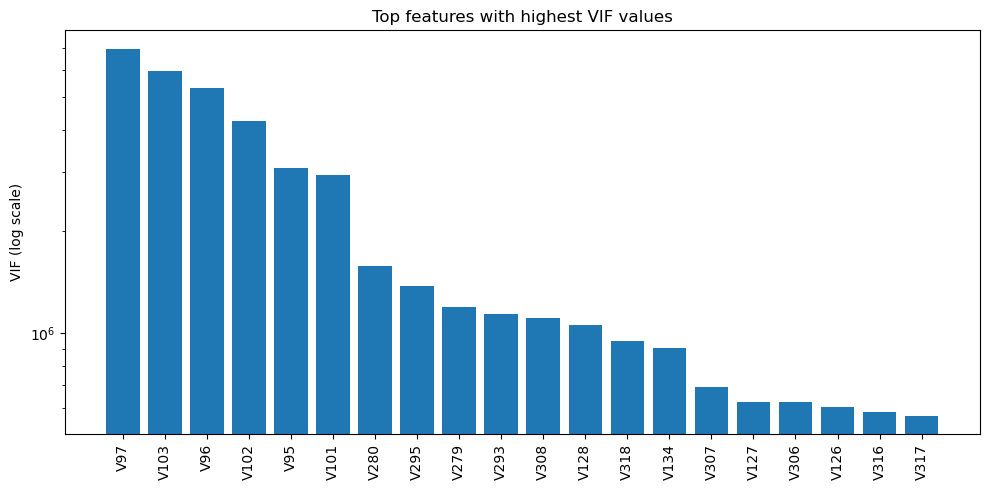

In [ ]:
import matplotlib.pyplot as plt

# sort and take top N
top_n = 20
vif_sorted = vif_data.sort_values("VIF", ascending=False).head(top_n)

plt.figure(figsize=(10, 5))
plt.bar(vif_sorted["feature"], vif_sorted["VIF"])
plt.yscale("log")  
plt.xticks(rotation=90)
plt.ylabel("VIF (log scale)")
plt.title("Top 20 features by highest VIF values")

plt.tight_layout()
plt.show()


In [27]:
baseline_a(missing_thresh=0.9, max_iter=1000, C=1,  solver="lbfgs")

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished


model 15 results:
ROC-AUC: 0.8461987882931993
PR-AUC: 0.3925295775628301


{'id': 15,
 'model': 'baseline_with_scaler',
 'ROC': 0.8461987882931993,
 'PR_AUC': 0.3925295775628301,
 'missing_thresh': 0.9,
 'C': 1.0,
 'max_iter': 1000,
 'solver': 'lbfgs',
 'penalty': 'l2',
 'class_weight': 'balanced',
 'time_min': 0.19,
 'model_path': 'models/baseline_15.pkl',
 'timestamp': '2026-02-09 21:14:36'}

In [ ]:
X_train_num = X_train_num_copy 
X_val_num = X_val_num_copy

## Models runner 

In [28]:
import os, time, joblib
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score


def train_model_callable(
    model_fn,
    model_name: str,
    missing_thresh: float = 0.9,
    save_dir: str = "models",
    **model_kwargs
):
    """
    model_fn: funkcja/klasa zwracająca estimator, np. XGBClassifier
    model_name: string do logów i nazwy pliku
    model_kwargs: parametry dla model_fn
    """
    MODEL_ID = _get_next_model_id()

    missing_rate = X_train_num.isna().mean()
    keep = missing_rate[missing_rate <= missing_thresh].index
    X_train_p = X_train_num[keep]
    X_val_p   = X_val_num[keep]

    estimator = model_fn(**model_kwargs)

    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", estimator),
    ])

    start_time = time.time()
    pipe.fit(X_train_p, y_train)
    duration = time.time() - start_time

    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_val_p)[:, 1]
    else:
        scores = pipe.decision_function(X_val_p)
        proba = 1 / (1 + np.exp(-scores))

    roc = roc_auc_score(y_val, proba)
    prauc = average_precision_score(y_val, proba)

    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, f"{model_name}_{MODEL_ID}.pkl")
    joblib.dump(pipe, model_path)

    record = {
        "id": MODEL_ID,
        "model": model_name,
        "ROC": float(roc),
        "PR_AUC": float(prauc),
        "missing_thresh": float(missing_thresh),
        "time_min": round(duration / 60, 2),
        "model_path": model_path,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_params": {k: (v.item() if hasattr(v, "item") else v) for k, v in model_kwargs.items()},
        "features_used": int(X_train_p.shape[1]),
    }

    _append_json_atomic(record)
    return record


In [32]:
X_train_num.shape

(472432, 211)

In [31]:
from xgboost import XGBClassifier

train_model_callable(
    model_fn=XGBClassifier,
    model_name="xgboost",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=R_S,
    use_label_encoder=False,
    eval_metric="logloss"
)


/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [21:32:45] WARNING: /opt/miniconda3/conda-bld/xgboost-split_1764761376052/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'id': 17,
 'model': 'xgboost',
 'ROC': 0.9249389632830772,
 'PR_AUC': 0.664918699398157,
 'missing_thresh': 0.9,
 'time_min': 0.21,
 'model_path': 'models/xgboost_17.pkl',
 'timestamp': '2026-02-09 21:32:52',
 'model_params': {'n_estimators': 400,
  'learning_rate': 0.05,
  'max_depth': 6,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'random_state': 42,
  'use_label_encoder': False,
  'eval_metric': 'logloss'},
 'features_used': 211}

In [34]:
X_train_num = X_train_num_copy 
X_val_num = X_val_num_copy

In [35]:
from xgboost import XGBClassifier

train_model_callable(
    model_fn=XGBClassifier,
    model_name="xgboost",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=R_S,
    use_label_encoder=False,
    eval_metric="logloss"
)


/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/xgboost/training.py:199: UserWarning: [21:35:02] WARNING: /opt/miniconda3/conda-bld/xgboost-split_1764761376052/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'id': 19,
 'model': 'xgboost',
 'ROC': 0.9316134725679343,
 'PR_AUC': 0.6917293874345875,
 'missing_thresh': 0.9,
 'time_min': 0.5,
 'model_path': 'models/xgboost_19.pkl',
 'timestamp': '2026-02-09 21:35:15',
 'model_params': {'n_estimators': 400,
  'learning_rate': 0.05,
  'max_depth': 6,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'random_state': 42,
  'use_label_encoder': False,
  'eval_metric': 'logloss'},
 'features_used': 391}

In [36]:
from lightgbm import LGBMClassifier

train_model_callable(
    model_fn=LGBMClassifier,
    model_name="lgbm",
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=R_S
)


[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.134090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36922
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 389
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101


/opt/anaconda3/envs/machine_learning/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'id': 20,
 'model': 'lgbm',
 'ROC': 0.9691152625519528,
 'PR_AUC': 0.8394730011645671,
 'missing_thresh': 0.9,
 'time_min': 1.29,
 'model_path': 'models/lgbm_20.pkl',
 'timestamp': '2026-02-09 21:38:14',
 'model_params': {'n_estimators': 3000,
  'learning_rate': 0.03,
  'num_leaves': 64,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'reg_lambda': 1.0,
  'n_jobs': -1,
  'random_state': 42},
 'features_used': 391}

In [43]:
from catboost import CatBoostClassifier

train_model_callable(
    model_fn=CatBoostClassifier,
    model_name="catboost",
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=R_S,
    verbose=False
)


{'id': 24,
 'model': 'catboost',
 'ROC': 0.9478644480966197,
 'PR_AUC': 0.7716951925045944,
 'missing_thresh': 0.9,
 'time_min': 9.84,
 'model_path': 'models/catboost_24.pkl',
 'timestamp': '2026-02-09 22:08:09',
 'model_params': {'iterations': 4000,
  'learning_rate': 0.03,
  'depth': 8,
  'loss_function': 'Logloss',
  'eval_metric': 'AUC',
  'random_seed': 42,
  'verbose': False},
 'features_used': 391}

In [40]:
from sklearn.ensemble import HistGradientBoostingClassifier

train_model_callable(
    model_fn=HistGradientBoostingClassifier,
    model_name="hgb",
    max_depth=8,
    learning_rate=0.05,
    max_iter=600,
    random_state=R_S
)


{'id': 21,
 'model': 'hgb',
 'ROC': 0.9412441348203597,
 'PR_AUC': 0.725509749121163,
 'missing_thresh': 0.9,
 'time_min': 1.69,
 'model_path': 'models/hgb_21.pkl',
 'timestamp': '2026-02-09 21:45:07',
 'model_params': {'max_depth': 8,
  'learning_rate': 0.05,
  'max_iter': 600,
  'random_state': 42},
 'features_used': 391}

In [42]:
from sklearn.ensemble import ExtraTreesClassifier

train_model_callable(
    model_fn=ExtraTreesClassifier,
    model_name="extratrees",
    n_estimators=600,
    max_depth=None,
    n_jobs=-1,
    random_state=R_S
)

{'id': 23,
 'model': 'extratrees',
 'ROC': 0.9279159671563209,
 'PR_AUC': 0.7219471416027412,
 'missing_thresh': 0.9,
 'time_min': 6.52,
 'model_path': 'models/extratrees_23.pkl',
 'timestamp': '2026-02-09 21:58:13',
 'model_params': {'n_estimators': 600,
  'max_depth': None,
  'n_jobs': -1,
  'random_state': 42},
 'features_used': 391}